In [1]:
import metobs_toolkit
import pandas as pd
import pandas as gpd
import numpy as np

Titanlib is not installed, install it manually if you want to use this functionallity.


In [2]:
climatebike = pd.read_csv("../code/results/output/e6a08fb8/climatebike_shade_mrt.csv")

In [3]:
climatebike['TIMESTAMP_dt'] = pd.to_datetime(climatebike['TIMESTAMP'])

In [110]:
climatebike_aug = pd.merge(climatebike[climatebike['TIMESTAMP_dt'].dt.month == 8][['RECORD']], climatebike, on='RECORD', how='inner')
climatebike_sept = pd.merge(climatebike[climatebike['TIMESTAMP_dt'].dt.month == 9][['RECORD']], climatebike, on='RECORD', how='inner')

In [111]:
import pandas as pd

def extract_datetime(gps_string):
    # Example: '230823115735N5222666E00452996G004-00018E0000N0...'
    day = gps_string[0:2]
    month = gps_string[2:4]
    year = "20" + gps_string[4:6]  # assuming 20XX
    hour = gps_string[6:8]
    minute = gps_string[8:10]
    second = gps_string[10:12]
    datetime_str = f"{day}/{month}/{year} {hour}:{minute}:{second}"
    return datetime_str

climatebike_aug["TIMESTAMP"] = climatebike_aug["GPSData"].apply(extract_datetime)
climatebike_sept["TIMESTAMP"] = climatebike_sept["GPSData"].apply(extract_datetime)

In [112]:
climatebike_aug = climatebike_aug.drop(['Unnamed: 0', 'TIMESTAMP_dt'], axis=1)
climatebike_sept = climatebike_sept.drop(['Unnamed: 0', 'TIMESTAMP_dt'], axis=1)

#### Method 1: Previous Value Filter

In [15]:
import pandas as pd
import numpy as np

# Let's assume you already have a DataFrame `df` with 'TIMESTAMP' and 'AirTemp'

# Step 1: Sort by time
df = climatebike_aug.sort_values(by='TIMESTAMP')

# Step 2: Calculate the difference between consecutive AirTemp values
climatebike_aug['AirTemp_diff'] = climatebike_aug['Air_Temp'].diff().abs()

# Step 3: Flag values where the change exceeds a threshold
# You can define a threshold — either a fixed number or based on statistics
threshold = climatebike_aug['AirTemp_diff'].mean() + 3 * climatebike_aug['AirTemp_diff'].std()
threshold

climatebike_aug['AirTemp_spike'] = climatebike_aug['AirTemp_diff'] > threshold

In [51]:
climatebike_aug[climatebike_aug['AirTemp_spike'] == True].shape[0]

229

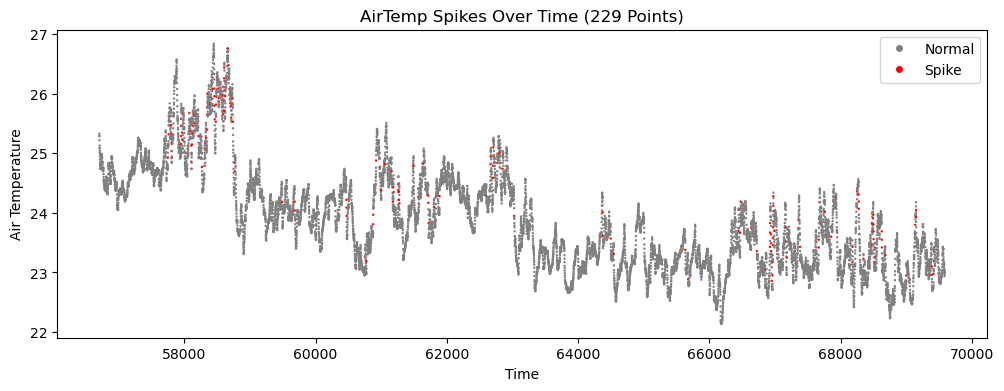

In [52]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Color points red if spike, gray otherwise
colors = climatebike_aug['AirTemp_spike'].map({True: 'red', False: 'gray'})

# Plot the scatter
plt.scatter(
    climatebike_aug['RECORD'],
    climatebike_aug['Air_Temp'],
    s=0.5,
    c=colors
)

# Add simple legend using proxy handles
plt.legend(
    handles=[
        plt.Line2D([0], [0], marker='o', color='w', label='Normal', markerfacecolor='gray', markersize=6),
        plt.Line2D([0], [0], marker='o', color='w', label='Spike', markerfacecolor='red', markersize=6)
    ],
    loc='upper right'
)

# Labels and title
plt.xlabel('Time')
plt.ylabel('Air Temperature')
plt.title('AirTemp Spikes Over Time (229 Points)')

plt.show()


### Method 2: Rolling Mean Difference Filter

In [116]:
window_size = 9  # choose an odd number so it's symmetrical
climatebike_aug['RollingMean'] = climatebike_aug['Air_Temp'].rolling(window=window_size, center=True).mean()
climatebike_sept['RollingMean'] = climatebike_sept['Air_Temp'].rolling(window=window_size, center=True).mean()

# Absolute difference from the rolling mean
climatebike_aug['AirTemp_diff_centered'] = (climatebike_aug['Air_Temp'] - climatebike_aug['RollingMean']).abs()
climatebike_sept['AirTemp_diff_centered'] = (climatebike_sept['Air_Temp'] - climatebike_sept['RollingMean']).abs()

# Flag spikes based on a threshold
threshold = climatebike_aug['AirTemp_diff_centered'].mean() + 3 * climatebike_aug['AirTemp_diff_centered'].std()
climatebike_aug['AirTemp_spike_2'] = climatebike_aug['AirTemp_diff_centered'] > threshold

threshold = climatebike_sept['AirTemp_diff_centered'].mean() + 3 * climatebike_sept['AirTemp_diff_centered'].std()
climatebike_sept['AirTemp_spike_2'] = climatebike_sept['AirTemp_diff_centered'] > threshold

In [103]:
climatebike_aug[climatebike_aug['AirTemp_spike_2'] == True].shape[0]

262

In [117]:
climatebike_sept[climatebike_sept['AirTemp_spike_2'] == True].shape[0]

375

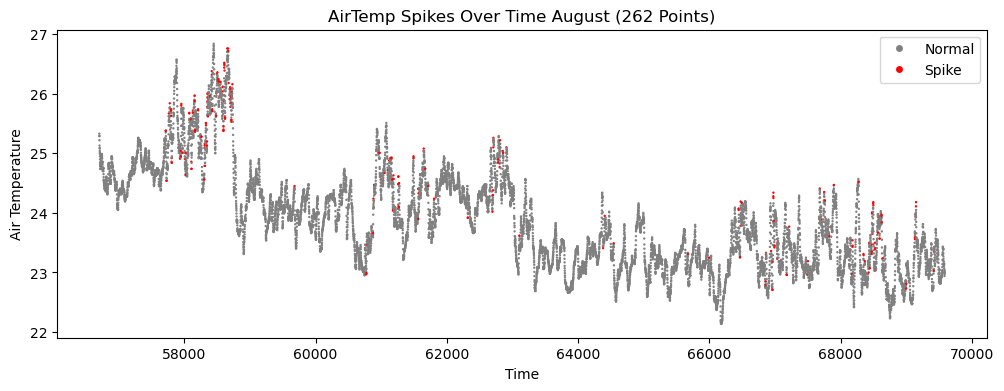

In [104]:
plt.figure(figsize=(12, 4))

# Color points red if spike, gray otherwise
colors = climatebike_aug['AirTemp_spike_2'].map({True: 'red', False: 'gray'})

# Assign the scatter plot to a variable so we can use it for the colorbar
sc = plt.scatter(
    climatebike_aug['RECORD'],
    climatebike_aug['Air_Temp'],
    s=0.5,
    c=colors
)

# Add simple legend using proxy handles
plt.legend(
    handles=[
        plt.Line2D([0], [0], marker='o', color='w', label='Normal', markerfacecolor='gray', markersize=6),
        plt.Line2D([0], [0], marker='o', color='w', label='Spike', markerfacecolor='red', markersize=6)
    ],
    loc='upper right'
)

# You can skip plt.legend() unless you have manually added labeled plots
plt.xlabel('Time')
plt.ylabel('Air Temperature')
plt.title('AirTemp Spikes Over Time August (262 Points)')
plt.show()

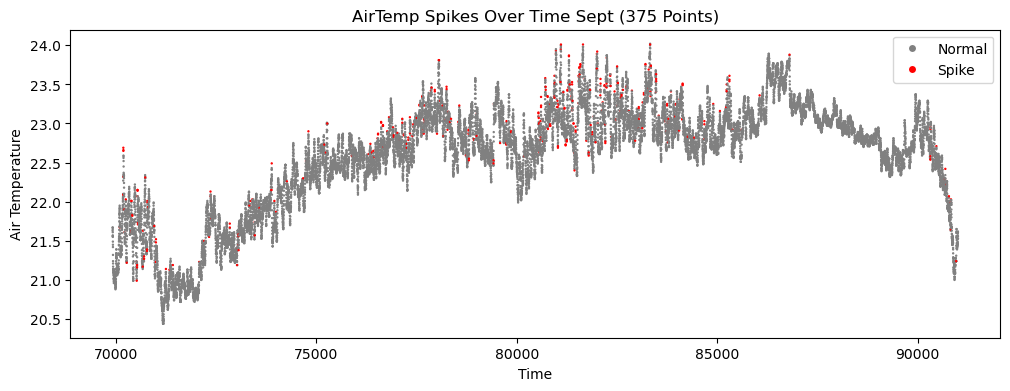

In [118]:
plt.figure(figsize=(12, 4))

# Color points red if spike, gray otherwise
colors = climatebike_sept['AirTemp_spike_2'].map({True: 'red', False: 'gray'})

# Assign the scatter plot to a variable so we can use it for the colorbar
sc = plt.scatter(
    climatebike_sept['RECORD'],
    climatebike_sept['Air_Temp'],
    s=0.5,
    c=colors
)

# Add simple legend using proxy handles
plt.legend(
    handles=[
        plt.Line2D([0], [0], marker='o', color='w', label='Normal', markerfacecolor='gray', markersize=6),
        plt.Line2D([0], [0], marker='o', color='w', label='Spike', markerfacecolor='red', markersize=6)
    ],
    loc='upper right'
)

# You can skip plt.legend() unless you have manually added labeled plots
plt.xlabel('Time')
plt.ylabel('Air Temperature')
plt.title('AirTemp Spikes Over Time Sept (375 Points)')
plt.show()

In [122]:
climatebike_aug_filtered = climatebike_aug[climatebike_aug["AirTemp_spike_2"] == False][['RECORD', 'AirTemp_spike_2']]
climatebike_sept_filtered = climatebike_sept[climatebike_sept["AirTemp_spike_2"] == False][['RECORD', 'AirTemp_spike_2']]
print(f"August: {climatebike_aug_filtered.shape[0]}, Sept: {climatebike_sept_filtered.shape[0]}")

August: 12595, Sept: 20673


In [121]:
climatebike_filtered = pd.concat([climatebike_aug_filtered, climatebike_sept_filtered], axis=0, ignore_index=True)

In [124]:
climatebike_filtered.to_csv("../data/clean_data/additional/e6a08fb8/climatebike_airtemp_filtered.csv")

### Method 3: Isolation Forest 1

In [72]:
from sklearn.ensemble import IsolationForest

model = IsolationForest(contamination=0.01, random_state=42)
model.fit(climatebike_aug[['Air_Temp']])
climatebike_aug['outlier'] = model.predict(climatebike_aug[['Air_Temp']])

In [73]:
climatebike_aug[climatebike_aug['outlier'] == -1]

,RECORD,TIMESTAMP,GPSData,Air_Temp,humidity,Qs_in,Qs_out,Qs_left,Qs_right,Qs_front,...,E_long_back,E_short_back,E_total_back,station,AirTemp_diff,AirTemp_spike,RollingMean,AirTemp_diff_centered,AirTemp_spike_2,outlier
1170,57876,23/08/2023 12:17:05,230823121705N5222447E00452977G006+00001E0000N0...,26.30,46.27,653.5,61.46,107.9,154.40,686.20,...,485.341271,44.093,529.434271,Mobi,0.02,False,26.312222,0.012222,False,-1
1171,57877,23/08/2023 12:17:06,230823121706N5222447E00452977G006+00001E0000N0...,26.32,46.21,653.7,61.46,107.0,157.80,686.80,...,485.733082,43.806,529.539082,Mobi,0.02,False,26.337778,0.017778,False,-1
1172,57878,23/08/2023 12:17:07,230823121707N5222447E00452977G006+00001E0000N0...,26.36,46.14,654.7,61.01,106.4,160.40,687.10,...,485.976779,43.806,529.782779,Mobi,0.04,False,26.371111,0.011111,False,-1
1173,57879,23/08/2023 12:17:08,230823121708N5222446E00452977G006+00000E0000N0...,26.38,46.11,656.0,61.01,106.6,162.90,687.90,...,486.098664,43.946,530.044664,Mobi,0.02,False,26.403333,0.023333,False,-1
1174,57880,23/08/2023 12:17:09,230823121709N5222446E00452977G006+00000E0000N0...,26.41,46.12,656.2,60.79,105.7,164.60,687.90,...,486.281538,44.240,530.521538,Mobi,0.03,False,26.435556,0.025556,False,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12035,68752,23/08/2023 15:18:21,230823151821N5222690E00457995G003+00002E0023N0...,22.23,55.67,419.4,42.62,283.1,54.30,63.56,...,415.975807,417.340,833.315807,Mobi,0.02,False,22.278889,0.048889,False,-1
12036,68753,23/08/2023 15:18:22,230823151822N5222691E00457997G003+00003E0024N0...,22.25,55.73,417.0,41.27,283.3,53.46,62.13,...,415.422720,423.290,838.712720,Mobi,0.02,False,22.284444,0.034444,False,-1
12037,68754,23/08/2023 15:18:23,230823151823N5222692E00457999G003+00003E0024N0...,22.25,55.83,418.9,37.24,292.5,51.77,60.70,...,415.422720,403.760,819.182720,Mobi,0.00,False,22.295556,0.045556,False,-1
12038,68755,23/08/2023 15:18:24,230823151824N5222693E00458000G003+00002E0022N0...,22.27,55.83,425.7,34.32,303.5,50.50,59.28,...,414.199656,409.850,824.049656,Mobi,0.02,False,22.310000,0.040000,False,-1


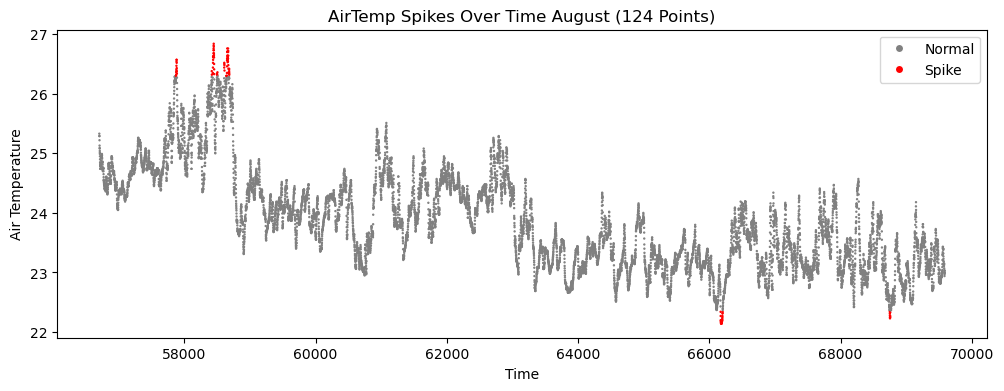

In [75]:
plt.figure(figsize=(12, 4))

# Color points red if spike, gray otherwise
colors = climatebike_aug['outlier'].map({-1: 'red', 1: 'gray'})

# Assign the scatter plot to a variable so we can use it for the colorbar
sc = plt.scatter(
    climatebike_aug['RECORD'],
    climatebike_aug['Air_Temp'],
    s=0.5,
    c=colors
)

# Add simple legend using proxy handles
plt.legend(
    handles=[
        plt.Line2D([0], [0], marker='o', color='w', label='Normal', markerfacecolor='gray', markersize=6),
        plt.Line2D([0], [0], marker='o', color='w', label='Spike', markerfacecolor='red', markersize=6)
    ],
    loc='upper right'
)

# You can skip plt.legend() unless you have manually added labeled plots
plt.xlabel('Time')
plt.ylabel('Air Temperature')
plt.title('AirTemp Spikes Over Time August (124 Points)')
plt.show()

### Method 3: Isolation Forest 2

In [78]:
from sklearn.svm import OneClassSVM

model = OneClassSVM(nu=0.01, kernel="rbf", gamma=0.1)
climatebike_aug['outlier'] = model.fit_predict(climatebike_aug[['Air_Temp']])

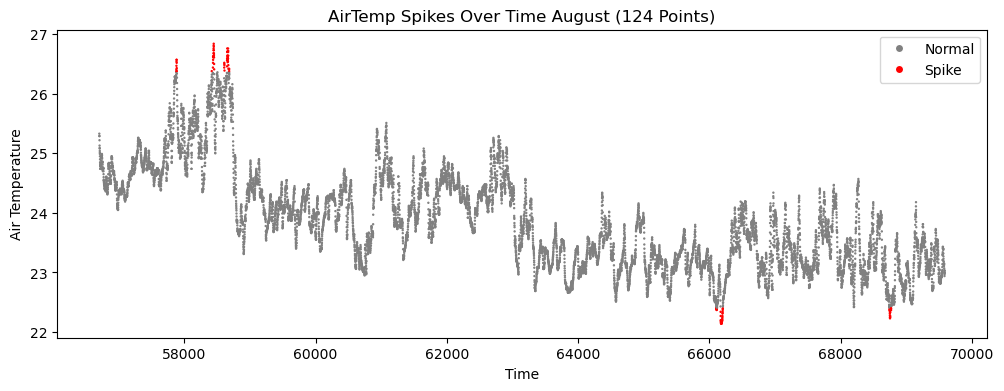

In [79]:
plt.figure(figsize=(12, 4))

# Color points red if spike, gray otherwise
colors = climatebike_aug['outlier'].map({-1: 'red', 1: 'gray'})

# Assign the scatter plot to a variable so we can use it for the colorbar
sc = plt.scatter(
    climatebike_aug['RECORD'],
    climatebike_aug['Air_Temp'],
    s=0.5,
    c=colors
)

# Add simple legend using proxy handles
plt.legend(
    handles=[
        plt.Line2D([0], [0], marker='o', color='w', label='Normal', markerfacecolor='gray', markersize=6),
        plt.Line2D([0], [0], marker='o', color='w', label='Spike', markerfacecolor='red', markersize=6)
    ],
    loc='upper right'
)

# You can skip plt.legend() unless you have manually added labeled plots
plt.xlabel('Time')
plt.ylabel('Air Temperature')
plt.title('AirTemp Spikes Over Time August (124 Points)')
plt.show()

### Method 3: Isolation Forest 3

In [113]:
from sklearn.neighbors import LocalOutlierFactor

lof = LocalOutlierFactor(n_neighbors=20)
climatebike_aug['outlier'] = lof.fit_predict(climatebike_aug[['Air_Temp']])

c:\Users\Dila Ozberkman\miniconda3\envs\shade_env\Lib\site-packages\sklearn\neighbors\_lof.py:322: UserWarning: Duplicate values are leading to incorrect results. Increase the number of neighbors for more accurate results.
  warnings.warn(


In [114]:
climatebike_aug[climatebike_aug['outlier']==-1].shape[0]

268

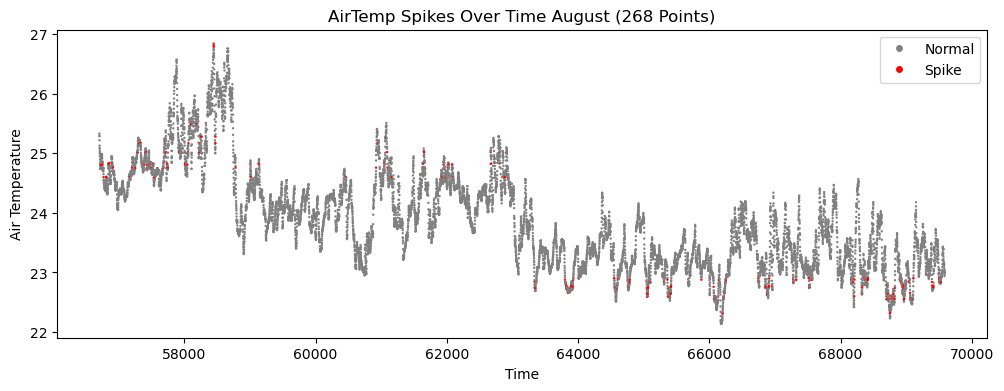

In [115]:
plt.figure(figsize=(12, 4))

# Color points red if spike, gray otherwise
colors = climatebike_aug['outlier'].map({-1: 'red', 1: 'gray'})

# Assign the scatter plot to a variable so we can use it for the colorbar
sc = plt.scatter(
    climatebike_aug['RECORD'],
    climatebike_aug['Air_Temp'],
    s=0.5,
    c=colors
)

# Add simple legend using proxy handles
plt.legend(
    handles=[
        plt.Line2D([0], [0], marker='o', color='w', label='Normal', markerfacecolor='gray', markersize=6),
        plt.Line2D([0], [0], marker='o', color='w', label='Spike', markerfacecolor='red', markersize=6)
    ],
    loc='upper right'
)

# You can skip plt.legend() unless you have manually added labeled plots
plt.xlabel('Time')
plt.ylabel('Air Temperature')
plt.title('AirTemp Spikes Over Time August (268 Points)')
plt.show()

### Method 3: Isolation Forest 4

In [86]:
from pyod.models.iforest import IForest
model = IForest()
model.fit(climatebike_aug[['Air_Temp']])
climatebike_aug['outlier'] = model.predict(climatebike_aug[['Air_Temp']])

c:\Users\Dila Ozberkman\miniconda3\envs\shade_env\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(


In [91]:
climatebike_aug[climatebike_aug['outlier'] == 1].shape[0]

1262

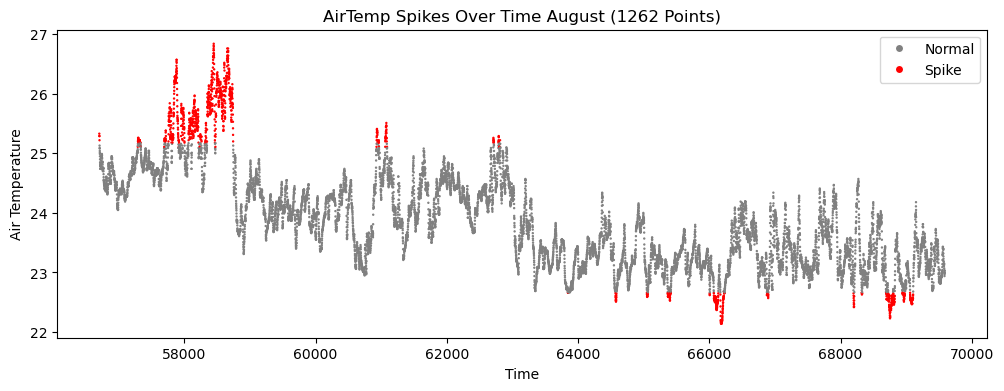

In [94]:
plt.figure(figsize=(12, 4))

# Color points red if spike, gray otherwise
colors = climatebike_aug['outlier'].map({1: 'red', 0: 'gray'})

# Assign the scatter plot to a variable so we can use it for the colorbar
sc = plt.scatter(
    climatebike_aug['RECORD'],
    climatebike_aug['Air_Temp'],
    s=0.5,
    c=colors
)

# Add simple legend using proxy handles
plt.legend(
    handles=[
        plt.Line2D([0], [0], marker='o', color='w', label='Normal', markerfacecolor='gray', markersize=6),
        plt.Line2D([0], [0], marker='o', color='w', label='Spike', markerfacecolor='red', markersize=6)
    ],
    loc='upper right'
)

# You can skip plt.legend() unless you have manually added labeled plots
plt.xlabel('Time')
plt.ylabel('Air Temperature')
plt.title('AirTemp Spikes Over Time August (1262 Points)')
plt.show()

In [ ]:
climatebike_aug = climatebike[climatebike['TIMESTAMP'].dt.month == 8]
climatebike_sept = climatebike[climatebike['TIMESTAMP'].dt.month == 9]